# Predicting Food Delivery Times Using Lasso and Decision Tree Regression
## A machine learning course project using data from Wolt

### Description of the project: 

In this project, I apply machine learning to a dataset describing food delivery orders made on the Wolt app in Helsinki in the fall of 2020. Data can be found here: https://github.com/woltapp/data-science-summer-intern-2022.

I decided to use the data to predict the delivery minutes of each order. In the data, Wolt provides information on the actual and predicted delivery minutes for each order. This made me curious about how accurate would predictions be compared to Wolt's own predictions if you used very simple machine learning models. That's what I set out to find out.

### The goal of the assignment:

Learn about machine learning.

### Contents of the notebook:

1. Data Preprocessing
2. Exploratory Data Analysis
3. Feature Engineering
4. Choosing the Features
5. Benchmark for model results: How good were Wolt's own prediction?
6. Models explained
7. Model Training and Validation
8. Model Selection
9. Conclusion

### Import relevant modules

In [1]:
# export
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import calendar
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import math
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle

### Load the data

In [2]:
orders2020 = pd.read_csv("orders_autumn_2020.csv")

# 1. Data Preprocessing

I want to 
1) separate the timestamps to date and time,
2) identify the weekday of each observation, 
3) create a column where the delivery time is rounded down to the hour. E.g. orders at 06:07:00 and 06:47:00 both get rounded down to 06:00:00. With this I can, if I want to, categorize orders by 1-hour windows. The window 06:00-07:00 would include orders that are rounded down to 06:00.

I create two helper functions. weekday helps with part 2), timestamp_floor with part 3).

In [3]:
def weekday(row):
    date = row.loc['DATE']
    day = calendar.day_name[date.weekday()]
    return day

In [4]:
def timestamp_floor(row):
    datetime = row.loc['TIMESTAMP']
    floor = pd.Timestamp(datetime).floor(freq='H')
    return floor

In [5]:
def hour_of_day(row):
    hour = int(row.loc['TIME'].strftime("%H"))+1
    return hour

In [6]:
orders = orders2020
orders = orders.rename(columns={'ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES': 'EST_ERROR', 
                                'ITEM_COUNT':'ITEMS', 'ESTIMATED_DELIVERY_MINUTES': 'EST_MIN', 
                                'ACTUAL_DELIVERY_MINUTES': 'ACT_MIN'})

orders['DATE'] = pd.to_datetime(orders['TIMESTAMP']).dt.date
orders['TIME'] = pd.to_datetime(orders['TIMESTAMP']).dt.time
orders['TIME_FLOOR'] = orders.apply(timestamp_floor, axis=1)
orders['TIME_FLOOR'] = pd.to_datetime(orders['TIME_FLOOR']).dt.time     # This is TIME rounded down to the hour.
orders['WEEKDAY'] = orders.apply(weekday, axis=1)                           # We match each date to a weekday
orders['HOUR_OF_DAY'] = orders.apply(hour_of_day,axis=1)                    # This matches each order to the hour of the day, which ranges from 1 to 24, i.e., 00:00-00:59 = 1, 01:00-01:59 = 2, ..., 23:00-23:59 = 24.


# Exploratory Data Analysis (EDA)

## Describe the data

In [7]:
orders2020.head()

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
0,2020-08-01 06:07:00.000,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0
1,2020-08-01 06:17:00.000,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0
2,2020-08-01 06:54:00.000,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0
3,2020-08-01 07:09:00.000,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0
4,2020-08-01 07:10:00.000,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0


In [8]:
orders2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18706 entries, 0 to 18705
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   TIMESTAMP                                             18706 non-null  object 
 1   ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  18706 non-null  int64  
 2   ITEM_COUNT                                            18706 non-null  int64  
 3   USER_LAT                                              18706 non-null  float64
 4   USER_LONG                                             18706 non-null  float64
 5   VENUE_LAT                                             18706 non-null  float64
 6   VENUE_LONG                                            18706 non-null  float64
 7   ESTIMATED_DELIVERY_MINUTES                            18706 non-null  int64  
 8   ACTUAL_DELIVERY_MINUTES                               18

In [9]:
orders2020.describe()

,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
count,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18429.000000,18429.000000,18429.000000,18706.000000
mean,-1.201058,2.688228,60.175234,24.941244,60.175643,24.941214,33.809313,32.608254,11.996853,16.973536,3.790991,0.332756
std,8.979834,1.886455,0.012674,0.016540,0.011509,0.014482,7.340283,10.018879,23.812605,3.411900,1.456017,1.129234
min,-41.000000,1.000000,60.153000,24.909000,60.149000,24.878000,10.000000,6.000000,0.000000,6.100000,0.077419,0.000000
25%,-7.000000,1.000000,60.163000,24.926000,60.167000,24.930000,28.000000,25.000000,0.000000,14.400000,2.696190,0.000000
50%,-2.000000,2.000000,60.175000,24.943000,60.170000,24.941000,33.000000,32.000000,0.000000,16.700000,3.631970,0.000000
75%,5.000000,4.000000,60.186000,24.954000,60.186000,24.950000,38.000000,40.000000,25.000000,18.900000,4.692530,0.000000
max,34.000000,11.000000,60.201000,24.980000,60.219000,25.042000,82.000000,58.000000,100.000000,26.700000,9.857300,6.315790


## Visualize the data

### Correlations

                EST_ERROR     ITEMS  USER_LAT  USER_LONG  VENUE_LAT  \
EST_ERROR        1.000000  0.060270  0.007620   0.011212   0.024282   
ITEMS            0.060270  1.000000 -0.024591  -0.002642  -0.032220   
USER_LAT         0.007620 -0.024591  1.000000   0.327151   0.783507   
USER_LONG        0.011212 -0.002642  0.327151   1.000000   0.306335   
VENUE_LAT        0.024282 -0.032220  0.783507   0.306335   1.000000   
VENUE_LONG      -0.014073 -0.042992  0.344495   0.604920   0.369177   
EST_MIN         -0.258966  0.043399 -0.053572  -0.011572  -0.108297   
ACT_MIN          0.706561  0.085816 -0.032420   0.001571  -0.057580   
CLOUD_COVERAGE   0.000927 -0.012549 -0.017789  -0.010004  -0.017738   
TEMPERATURE      0.019129  0.015198  0.007031  -0.005069   0.008792   
WIND_SPEED       0.027668 -0.005275 -0.000166   0.005153   0.002711   
PRECIPITATION    0.039914  0.013170 -0.005649   0.009511  -0.007295   

                VENUE_LONG   EST_MIN   ACT_MIN  CLOUD_COVERAGE  TEMPERATURE 

<AxesSubplot:>

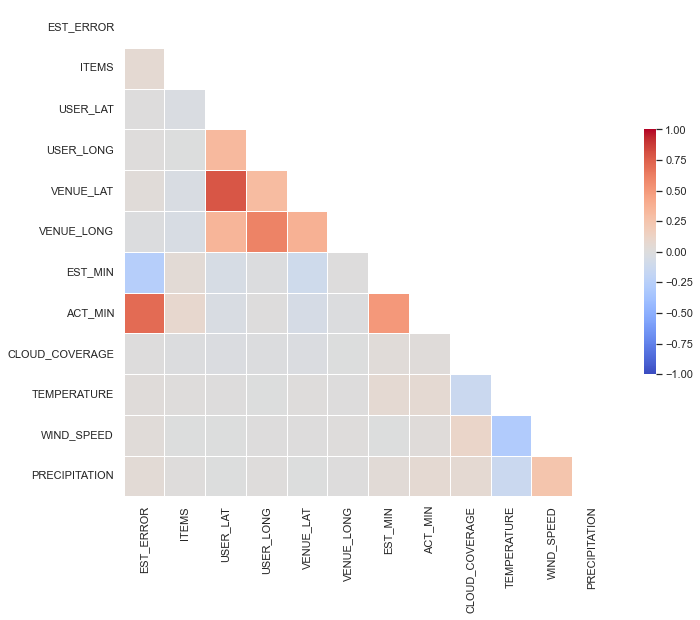

In [10]:
corr = orders.drop(columns=['TIME','DATE','WEEKDAY','TIMESTAMP','HOUR_OF_DAY', 'TIME_FLOOR']).corr()
print(corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The pairplot below doesn't seem to indicate any obvious relationships between the variables except for the variables related to delivery minutes, which naturally are related to each other.

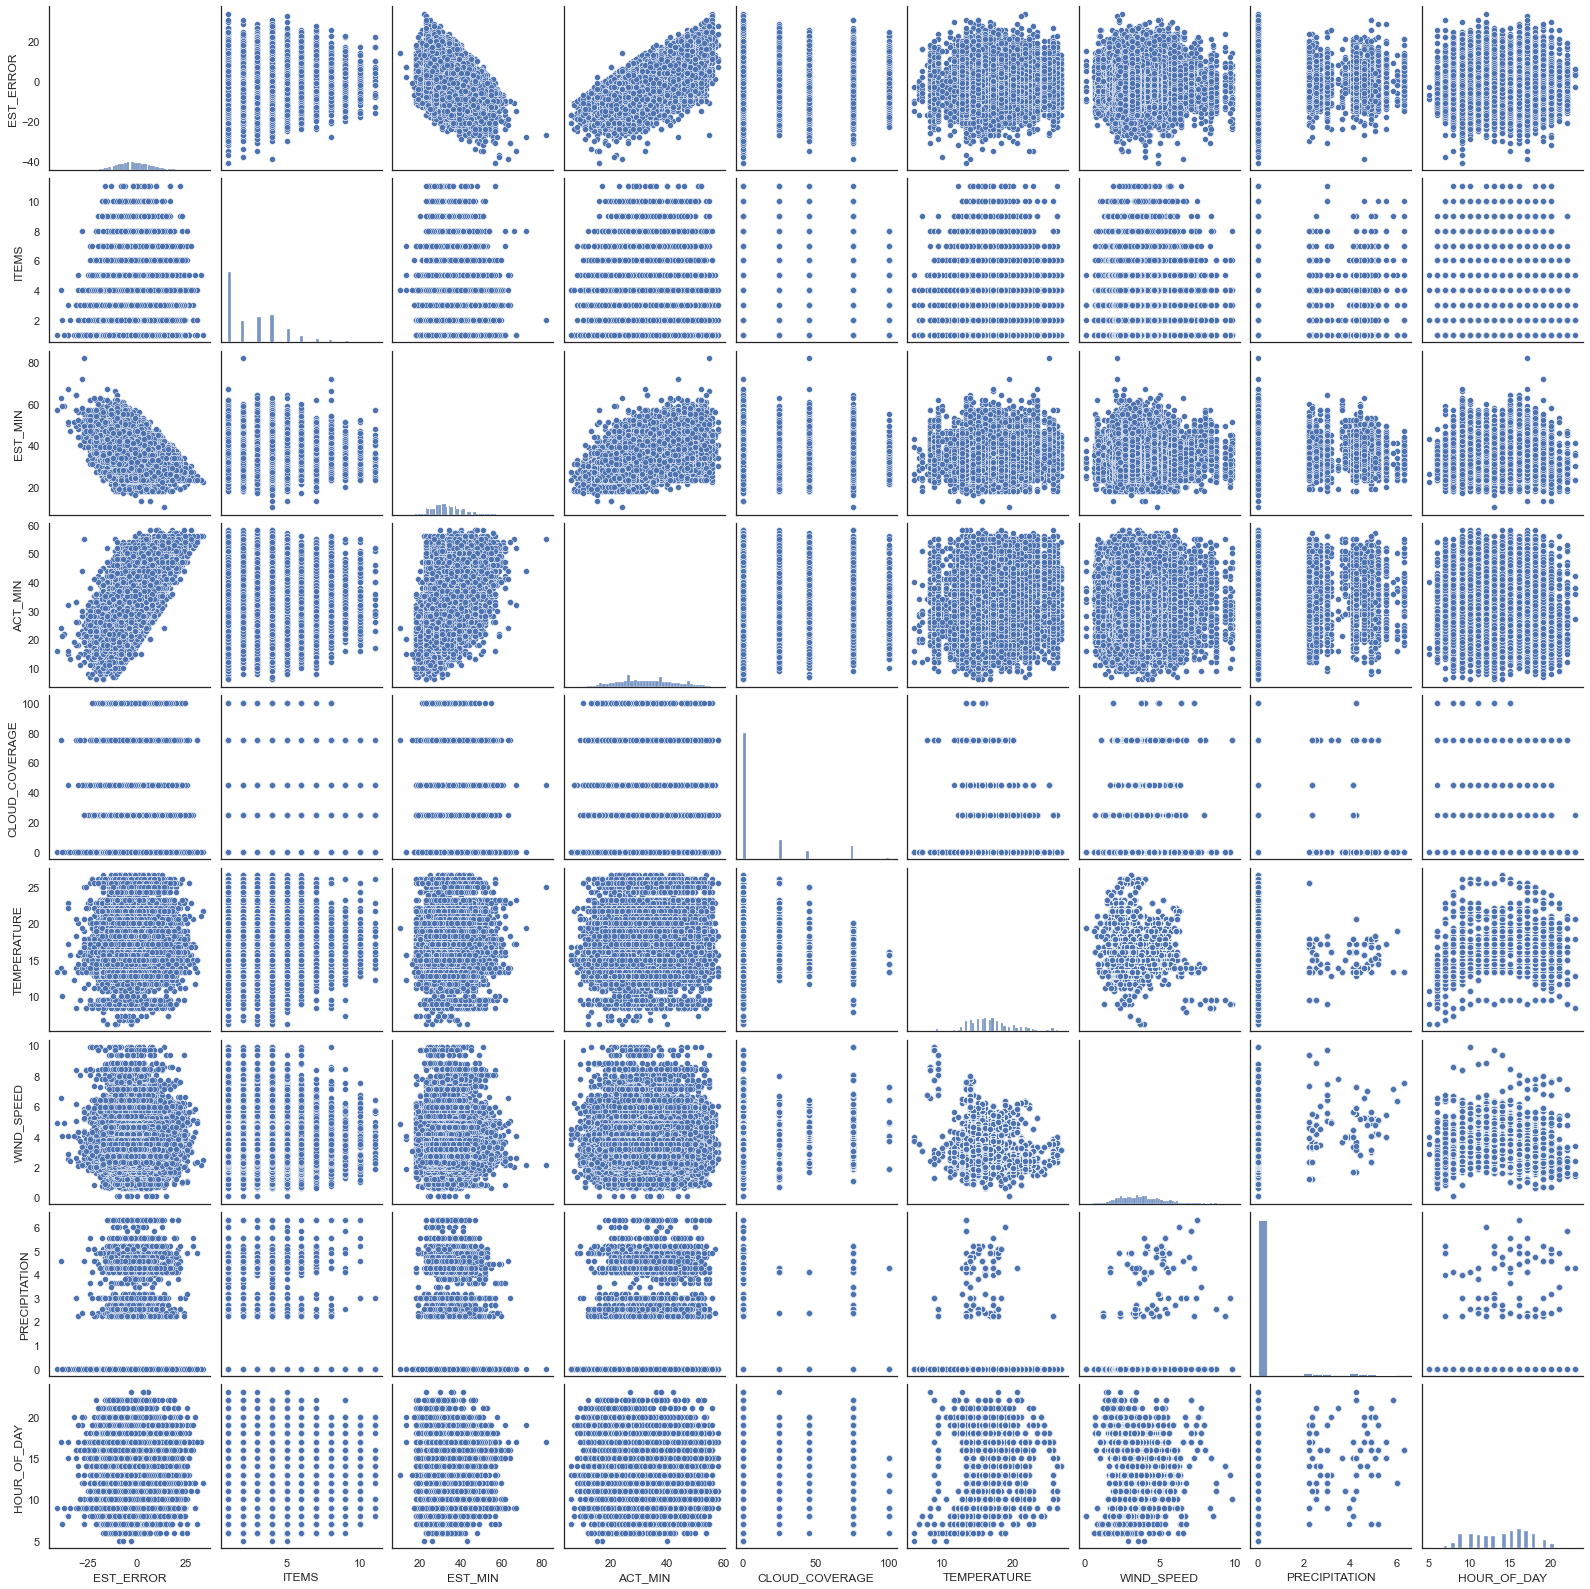

In [11]:
sns.pairplot(orders.drop(columns=['USER_LAT','USER_LONG','VENUE_LAT','VENUE_LONG','TIMESTAMP','DATE','WEEKDAY','TIME','TIME_FLOOR']))

### Heatmaps

Let's see how orders are distributed across the two month period and hours of the day. To do this, we have to count how many orders were delivered by the hour.

In [12]:
orders_by_hour = orders.groupby(by=["DATE","TIME_FLOOR"], as_index=False).count()
orders_by_hour = orders_by_hour.loc[:,["DATE","TIME_FLOOR","ITEMS"]]
orders_by_hour = orders_by_hour.rename(columns={"ITEMS": "ORDERS"})
orders_by_hour['WEEKDAY'] = orders_by_hour.apply(weekday, axis=1)
orders_by_hour

,DATE,TIME_FLOOR,ORDERS,WEEKDAY
0,2020-08-01,06:00:00,3,Saturday
1,2020-08-01,07:00:00,6,Saturday
2,2020-08-01,08:00:00,15,Saturday
3,2020-08-01,09:00:00,20,Saturday
4,2020-08-01,10:00:00,26,Saturday
...,...,...,...,...
935,2020-09-30,16:00:00,42,Wednesday
936,2020-09-30,17:00:00,26,Wednesday
937,2020-09-30,18:00:00,19,Wednesday
938,2020-09-30,19:00:00,8,Wednesday


We join these order counts to the 'orders' dataframe as a new feature:

In [13]:
orders = pd.merge(orders, orders_by_hour, how='left',on=['DATE','TIME_FLOOR','WEEKDAY'])
orders.head(2)

,TIMESTAMP,EST_ERROR,ITEMS,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,EST_MIN,ACT_MIN,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,DATE,TIME,TIME_FLOOR,WEEKDAY,HOUR_OF_DAY,ORDERS
0,2020-08-01 06:07:00.000,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0,2020-08-01,06:07:00,06:00:00,Saturday,7,3
1,2020-08-01 06:17:00.000,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0,2020-08-01,06:17:00,06:00:00,Saturday,7,3


In [14]:
ts = pd.Series(pd.date_range(start="2020-08-01", end="2020-10-01", freq="H"))
ts = ts[:-1]
timeframe = pd.DataFrame(ts, columns=["TIMESTAMP"])
timeframe['DATE'] = pd.to_datetime(timeframe['TIMESTAMP']).dt.date
timeframe['TIME_FLOOR'] = pd.to_datetime(timeframe['TIMESTAMP']).dt.time
timeframe = timeframe.set_index('TIMESTAMP')
timeframe = timeframe.between_time('04:00:00','22:00:00',include_start=True,include_end=True)
counts = pd.merge(timeframe, orders_by_hour, how='outer')
counts['ORDERS'] = counts['ORDERS'].fillna(0)
counts['WEEKDAY'] = counts.apply(weekday, axis=1)
counts

,DATE,TIME_FLOOR,ORDERS,WEEKDAY
0,2020-08-01,04:00:00,0.0,Saturday
1,2020-08-01,05:00:00,0.0,Saturday
2,2020-08-01,06:00:00,3.0,Saturday
3,2020-08-01,07:00:00,6.0,Saturday
4,2020-08-01,08:00:00,15.0,Saturday
...,...,...,...,...
1154,2020-09-30,18:00:00,19.0,Wednesday
1155,2020-09-30,19:00:00,8.0,Wednesday
1156,2020-09-30,20:00:00,1.0,Wednesday
1157,2020-09-30,21:00:00,0.0,Wednesday


Text(0, 0.5, 'Hour')

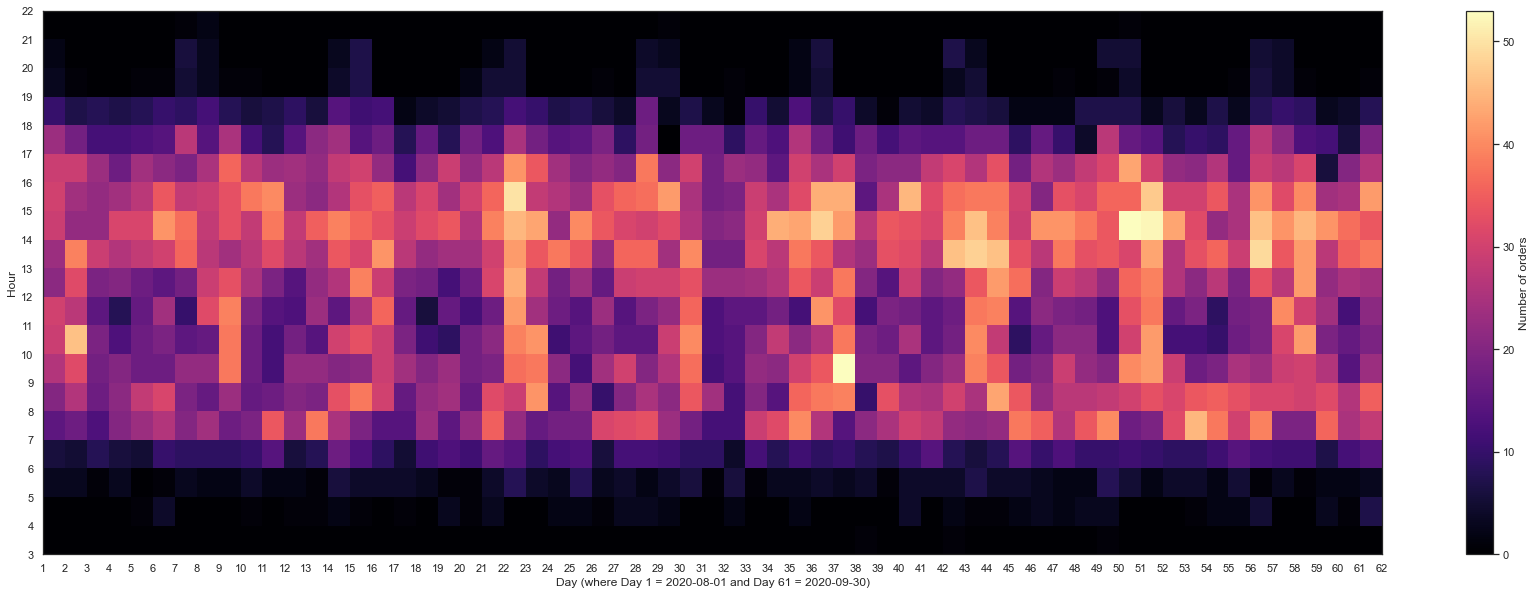

In [15]:
xgrid = np.arange(len(counts['DATE'].unique()) + 1) +1
ygrid = np.arange(3,23)
no_orders = counts['ORDERS'].values.reshape(19, len(counts['DATE'].unique()), order="F")

plt.figure(figsize=(30,10))
plt.pcolormesh(xgrid, ygrid, no_orders, cmap='magma', vmin=0,vmax=counts['ORDERS'].max())

cbar = plt.colorbar()
cbar.ax.set_ylabel('Number of orders')

plt.xticks(np.arange(min(xgrid), max(xgrid)+1, 1.0))
plt.yticks(np.arange(min(ygrid), max(ygrid)+1, 1.0))
plt.xlabel("Day (where Day 1 = 2020-08-01 and Day 61 = 2020-09-30)")
plt.ylabel("Hour")

- You can clearly distinguish that peak demand hours seem to start somewhere after noon pretty much for every day of the week
- Demand starts to taper off around 6 pm. 
- For some days of the week, but not all, breakfast and lunch are busy hours
- Demand during breakfast and lunch hours increases from August to September - people coming back to work and the city after summer holidays?
- This visual appraisal leads me to think that demand during evening hours is surprisingly weak - is demand driven mostly by people at work and businesses?

## Conclusions from the EDA

There are very few clear relationships between variables except the obvious ones. I have therefore decided to do feature engineering in the hopes that it will give me features that are actually useful in predicting delivery minutes.

# 2. Feature Engineering

## Adding distances between users and venues

In [16]:
def beeline_distance(row):
    """ Returns the distance between a user and a venue using the haversine formula on their coordinates. """
    
    user_lat = row['USER_LAT']
    user_long = row['USER_LONG']
    venue_lat = row['VENUE_LAT']
    venue_long = row['VENUE_LONG']
    
    R = 6371000                      # Earth's radius in meters
    ϕ1 = user_lat * math.pi/180      # Latitude in radians
    ϕ2 = venue_lat * math.pi/180     # Latitude in radians
    Δϕ = (ϕ1-ϕ2) * math.pi/180       # Difference in latitudes, radians
    Δλ = (user_long-venue_long) * math.pi/180       # Difference in longitudes, radians
    
    a = math.sin(Δϕ/2) * math.sin(Δϕ/2) + math.cos(ϕ1) * math.cos(ϕ2) * math.sin(Δλ/2) * math.sin(Δλ/2);
    c = 2 * math.atan2(math.sqrt(a),math.sqrt(1-a))
    dist = R*c
    
    return dist

In [17]:
orders['DISTANCE'] = orders.apply(beeline_distance,axis=1) 

In [18]:
orders.head(2)

,TIMESTAMP,EST_ERROR,ITEMS,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,EST_MIN,ACT_MIN,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,DATE,TIME,TIME_FLOOR,WEEKDAY,HOUR_OF_DAY,ORDERS,DISTANCE
0,2020-08-01 06:07:00.000,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0,2020-08-01,06:07:00,06:00:00,Saturday,7,3,3.881435
1,2020-08-01 06:17:00.000,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0,2020-08-01,06:17:00,06:00:00,Saturday,7,3,940.839065


### How is distance related to delivery minutes?

Here we plot distance against actual delivery minutes. Colors describe whether order was late (lighter colors) or early (darker colors). There doesn't seem to be a self evident relationship between distance and actual delivery minutes, though common sense says that distance is probably the best predictor of delivery times. One thing to note is that it looks like late orders (lighter colored dots) are more common for shorter distances than longer. This is probably due to Wolt also assuming that the delivery shouldn't take long for such a short distance like 1 km, but then something goes wrong with the venue or the driver, and delivery is delayed. Also people are more likely to order from venues close to them than from those far away.

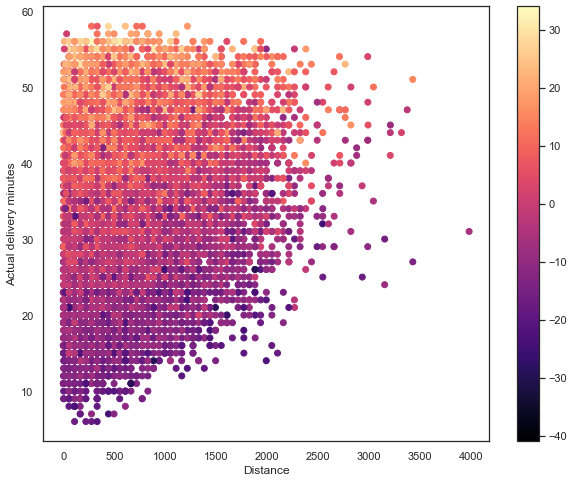

In [19]:
plt.figure(figsize=(10,8))
plt.scatter(orders['DISTANCE'], orders['ACT_MIN'], c=orders['EST_ERROR'], cmap='magma')
plt.xlabel("Distance")
plt.ylabel("Actual delivery minutes")
plt.colorbar()
plt.show()

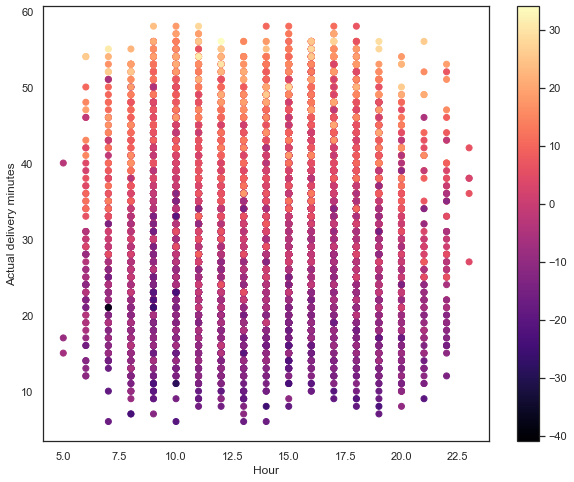

In [20]:
plt.figure(figsize=(10,8))
plt.scatter(orders['HOUR_OF_DAY'], orders['ACT_MIN'], c=orders['EST_ERROR'], cmap='magma')
plt.xlabel("Hour")
plt.ylabel("Actual delivery minutes")
plt.colorbar()
plt.show()

## Dropping features I won't use

To predict delivery minutes (label), I want to use as features distance, the day of the week, and the time of day. At this point, I'm going to drop unnecessary variables from the dataframe.

I wanted to use HOUR_OF_DAY, but decided not to. I would have to one hot encode it in order to be abse to use it as a feature in Lasso regression, which assumes a linear relationship between the features and the label. One hot encoding the variable HOUR_OF_DAY would, however, create way too many features for the scope of this project (although they would be simple binary variables). 

In [21]:
#df = orders.loc[:,['ACT_MIN','DISTANCE','ITEMS','WEEKDAY','HOUR_OF_DAY']]
df = orders.loc[:,['ACT_MIN','DISTANCE','ITEMS','WEEKDAY']]

In [22]:
df.head()

,ACT_MIN,DISTANCE,ITEMS,WEEKDAY
0,10,3.881435,1,Saturday
1,32,940.839065,8,Saturday
2,6,110.668634,4,Saturday
3,26,2377.147170,3,Saturday
4,26,331.858776,2,Saturday


## One hot encoding weekday and hour

Why? Because WEEKDAY is a categorical variable that I want to make binary.

In [23]:
df = pd.concat([df, pd.get_dummies(df['WEEKDAY'])], axis=1)
#df = pd.concat([df, pd.get_dummies(df['HOUR_OF_DAY'])], axis=1)
df

,ACT_MIN,DISTANCE,ITEMS,WEEKDAY,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,10,3.881435,1,Saturday,0,0,1,0,0,0,0
1,32,940.839065,8,Saturday,0,0,1,0,0,0,0
2,6,110.668634,4,Saturday,0,0,1,0,0,0,0
3,26,2377.147170,3,Saturday,0,0,1,0,0,0,0
4,26,331.858776,2,Saturday,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
18701,23,55.311498,1,Wednesday,0,0,0,0,0,0,1
18702,15,276.794254,6,Wednesday,0,0,0,0,0,0,1
18703,11,386.999589,3,Wednesday,0,0,0,0,0,0,1
18704,10,55.853594,3,Wednesday,0,0,0,0,0,0,1


            ACT_MIN  DISTANCE     ITEMS    Friday    Monday  Saturday  \
ACT_MIN    1.000000  0.211152  0.085816  0.027149  0.024273 -0.043577   
DISTANCE   0.211152  1.000000  0.001072 -0.005470 -0.010175  0.017093   
ITEMS      0.085816  0.001072  1.000000  0.006152 -0.019989  0.030087   
Friday     0.027149 -0.005470  0.006152  1.000000 -0.153461 -0.190839   
Monday     0.024273 -0.010175 -0.019989 -0.153461  1.000000 -0.170288   
Saturday  -0.043577  0.017093  0.030087 -0.190839 -0.170288  1.000000   
Sunday     0.051570 -0.002493  0.030125 -0.193451 -0.172619 -0.214662   
Thursday  -0.026095 -0.004980 -0.016911 -0.153500 -0.136970 -0.170331   
Tuesday   -0.010197 -0.007859 -0.023278 -0.155083 -0.138383 -0.172088   
Wednesday -0.025877  0.011404 -0.016024 -0.164645 -0.146915 -0.182698   

             Sunday  Thursday   Tuesday  Wednesday  
ACT_MIN    0.051570 -0.026095 -0.010197  -0.025877  
DISTANCE  -0.002493 -0.004980 -0.007859   0.011404  
ITEMS      0.030125 -0.016911 -0.0232

<AxesSubplot:>

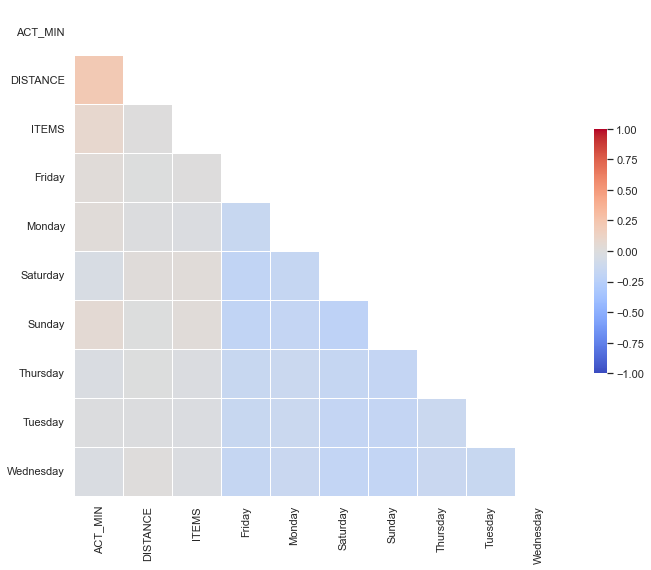

In [24]:
#corr = df.drop(columns=['WEEKDAY','HOUR_OF_DAY']).corr()
corr = df.drop(columns=['WEEKDAY']).corr()
print(corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 4. Features and label

In [25]:
df = df.drop(columns=['WEEKDAY'])
df.columns = ['Delivery minutes','Distance','Items',
                'Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']
df = df.reindex(columns=['Delivery minutes','Distance','Items',
                        'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
df

,Delivery minutes,Distance,Items,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,10,3.881435,1,0,0,0,0,0,1,0
1,32,940.839065,8,0,0,0,0,0,1,0
2,6,110.668634,4,0,0,0,0,0,1,0
3,26,2377.147170,3,0,0,0,0,0,1,0
4,26,331.858776,2,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
18701,23,55.311498,1,0,0,1,0,0,0,0
18702,15,276.794254,6,0,0,1,0,0,0,0
18703,11,386.999589,3,0,0,1,0,0,0,0
18704,10,55.853594,3,0,0,1,0,0,0,0


## Features and label into Numpy arrays

In [26]:
X = df.drop(columns=['Delivery minutes']).to_numpy() # Weekdays, items, and distance as features
y = df['Delivery minutes'].to_numpy()                # Delivery minutes as label      

In [27]:
print(X.shape)
print(y.shape)

(18706, 9)
(18706,)


## Splitting the data

Split into training (70%), validation (15%), and test (15%) data.

In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=66)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=66)

# 5. Benchmark - how good were Wolt's predictions?

Mean squared error for Wolt's predictions

In [29]:
wolt_MSE = mean_squared_error(orders['EST_MIN'],orders['ACT_MIN'])
wolt_MSE

82.07564417833851

Shares of orders that were not terribly late

In [30]:
on_time = sum(np.where(orders['EST_ERROR']==0, 1, 0))
within_5_min = sum(np.where(abs(orders['EST_ERROR'])<=5, 1, 0))
within_10_min = sum(np.where(abs(orders['EST_ERROR'])<=10, 1, 0))

print(f"{on_time} out of Wolt's {len(orders)} orders were exactly on time. So {round(on_time/len(orders)*100,1)} % of orders were delivered on time.")
print(f"{within_5_min} out of Wolt's {len(orders)} orders were ordered within 5 minutes of the estimated time. So {round(within_5_min/len(orders)*100,1)} % of orders were delivered within 5 minutes of estimated delivery.")
print(f"{within_10_min} out of Wolt's {len(orders)} orders were ordered within 10 minutes of the estimated time. So {round(within_10_min/len(orders)*100,1)} % of orders were delivered within 10 minutes of estimated delivery.")

789 out of Wolt's 18706 orders were exactly on time. So 4.2 % of orders were delivered on time.
8440 out of Wolt's 18706 orders were ordered within 5 minutes of the estimated time. So 45.1 % of orders were delivered within 5 minutes of estimated delivery.
14044 out of Wolt's 18706 orders were ordered within 10 minutes of the estimated time. So 75.1 % of orders were delivered within 10 minutes of estimated delivery.


Here we plot actual delivery minutes against estimated delivery minutes. Colors describe whether order was late (lighter colors) or early (darker colors). The blue line depicts orders that were exactly on time. The area between the two green lines contains orders which were at most 10 minutes early or late. Therefore all data points outside the area depict orders for which Wolt's estimated delivery minutes was off by over 10 minutes. When looking at the scatter this way, we see that Wolt's predictions are often not very accurate. It is difficult to give accurate predictions.

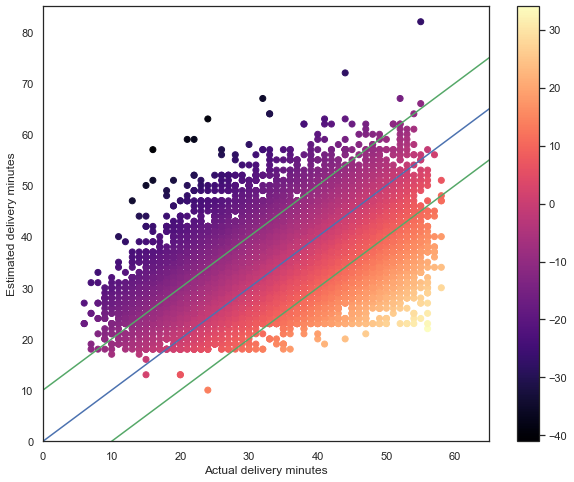

In [31]:
plt.figure(figsize=(10,8))
plt.scatter(orders['ACT_MIN'], orders['EST_MIN'], c=orders['EST_ERROR'], cmap='magma')
plt.xlabel("Actual delivery minutes")
plt.ylabel("Estimated delivery minutes")
plt.colorbar()
plt.plot([0, 80], [0, 80], color = 'b')
plt.plot([0, 80], [10, 90], color = 'g')
plt.plot([10, 70], [0, 60], color = 'g')
plt.xlim(0, 65)
plt.ylim(0, 85)
plt.show()

# 6. Models

In Linear regression, the hypothesis space is

$\begin{equation*}
\begin{aligned}
\mathscr{H}^{(n)} := \{h^{(w)}: \mathbb{R}^n \rightarrow \mathbb{R}: h^{(w)} := w^Tx \text{ with some parameter vector } w \in \mathbb{R}^n \}
\end{aligned}
\end{equation*}
$.

The loss function is

$\begin{equation*}
\begin{aligned}
L\left((x,y),h^{(w)}\right) = (y-w^Tx)^2
\end{aligned}
\end{equation*}$.

## Lasso

I chose Lasso as one of the methods because it performs regularizations as well as feature selection. I was not sure which features to use so this seemed useful.

In Lasso regression, the hypothesis space is

$\begin{equation*}
\begin{aligned}
\mathscr{H}^{(n)} := \{h^{(w)}: \mathbb{R}^n \rightarrow \mathbb{R}: h^{(w)} := w^Tx \text{ with some parameter vector } w \in \mathbb{R}^n \}
\end{aligned}
\end{equation*}$.

The loss function is

$\begin{equation*}
\begin{aligned}
L\left((x,y),h^{(w)}\right) = (y-w^Tx)^2 + \lambda ||w||_1
\end{aligned}
\end{equation*}$

where we have the penalty term $\lambda ||w||_1$, where $\lambda$ is the tuning parameter and $||w||_1$ is the L1 norm. 

## Tree Regression

I chose tree regression as the other model because I had not used it before.

I can't really formulate this model. I used absolute error as the loss in the hopes it would make the model more robust.

# 7. Training and Validation

In [32]:
model_selection = {}

## Lasso

In [33]:
# we will use this variables to store the resulting training/validation errors for each polynomial degree 
# NB - this time we have multiple errors (for each CV step) for each degree, so we store the errors in a dictionary

tr_errors = []                            # for recording training erros for different values of λ       
val_errors = []                           # for recording validation erros for different values of λ   
comparison = {}                           # for comparing parameter values
coefs = np.empty((10,12),dtype=float)     # for saving the coefficients and intercept corresponding to different values of λ

for i in range(-3,5,1):
    
    k = 10**i
    # Fit model    
    regr = Lasso(alpha=k,fit_intercept=True) 
    regr.fit(X_train, y_train)

    # Now we compute the errors on train and validation data obtained from kfold
    y_pred_train = regr.predict(X_train)    # predict using the linear model
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = regr.predict(X_val) # predict labels for the validation data using the linear model 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
        
    # Save errors
    tr_errors.append(tr_error)          # We save the training error for tree depth = k
    val_errors.append(val_error)        # We save the validation error for tree depth = k
    comparison[k] = val_error 
    
print("(λ, training error):") 
print(list(zip([10**x for x in range(-3,5,1)],tr_errors)))
print()
print("(λ, validation error):") 
print(list(zip([10**x for x in range(-3,5,1)],val_errors)))
print()

best_lasso_model = min(comparison, key=comparison.get)
print(f"Lowest validation error with k = {best_lasso_model}")

(λ, training error):
[(0.001, 92.77551207426266), (0.01, 92.77976077406083), (0.1, 93.10463263185866), (1, 93.6644693254213), (10, 94.40585296734797), (100, 94.44913492689943), (1000, 98.69925585832827), (10000, 98.69925585832827)]

(λ, validation error):
[(0.001, 95.49095535504158), (0.01, 95.47083667000392), (0.1, 95.56542772573454), (1, 95.73842865003074), (10, 96.29389552607248), (100, 96.35300108468215), (1000, 100.82953177864026), (10000, 100.82953177864026)]

Lowest validation error with k = 0.01


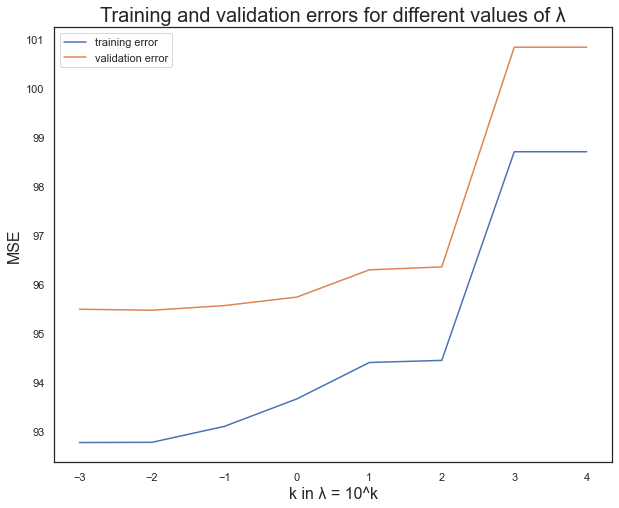

In [34]:
plt.figure(figsize=(10,8))
plt.plot(range(-3,5,1),tr_errors, label="training error")
plt.plot(range(-3,5,1),val_errors, label="validation error")
plt.legend(loc="best")    # set the location of the legend
plt.ylabel('MSE',fontsize=16)
plt.xlabel('k in λ = 10^k',fontsize=16)
plt.title(f'Training and validation errors for different values of λ',fontsize=20)    # set the title
plt.show()

### How did this method do compared to Wolt

In [35]:
lasso_regr = Lasso(alpha=best_lasso_model)
lasso_regr.fit(X_train,y_train)
lasso_ypred = lasso_regr.predict(X_test)
lasso_mse = mean_squared_error(y_test,lasso_ypred)
model_selection['Lasso'] = lasso_mse

print(lasso_mse)

95.82393865290001


In [36]:
diff = y_test-lasso_ypred

my_on_time = sum(np.where(diff==0, 1, 0))
my_within_5_min = sum(np.where(abs(diff)<=5, 1, 0))
my_within_10_min = sum(np.where(abs(diff)<=10, 1, 0))

print(f"{my_on_time} out of {len(y_test)} test predictions were exactly on time. So {round(my_on_time/len(y_test)*100,1)} % of orders were on time.")
print(f"{my_within_5_min} out of {len(y_test)} test predictions were ordered within 5 minutes of the estimated time. So {round(my_within_5_min/len(y_test)*100,1)} % of orders were within 5 minutes of estimated delivery.")
print(f"{my_within_10_min} out of {len(y_test)} test predictions were ordered within 10 minutes of the estimated time. So {round(my_within_10_min/len(y_test)*100,1)} % of orders were within 10 minutes of estimated delivery.")

0 out of 5612 test predictions were exactly on time. So 0.0 % of orders were on time.
1978 out of 5612 test predictions were ordered within 5 minutes of the estimated time. So 35.2 % of orders were within 5 minutes of estimated delivery.
3717 out of 5612 test predictions were ordered within 10 minutes of the estimated time. So 66.2 % of orders were within 10 minutes of estimated delivery.


## Decision tree regression

In [37]:
# we will use this variables to store the resulting training/validation errors for each polynomial degree 
# NB - this time we have multiple errors (for each CV step) for each degree, so we store the errors in a dictionary

tr_errors = []                            # for recording training erros for different values of λ       
val_errors = []                           # for recording validation erros for different values of λ   
comparison = {}                           # for comparing parameter values
coefs = np.empty((10,12),dtype=float)     # for saving the coefficients and intercept corresponding to different values of λ

for k in range(1,14,1):

    # Fit model    
    regr = DecisionTreeRegressor(max_depth=k, criterion="absolute_error")
    regr.fit(X_train, y_train)

    # Now we compute the errors on train and validation data obtained from kfold
    y_pred_train = regr.predict(X_train)    # predict using the linear model
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = regr.predict(X_val) # predict labels for the validation data using the linear model 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
        
    # Save errors
    tr_errors.append(tr_error)             # We save the training error for tree depth = k
    val_errors.append(val_error)           # We save the validation error for tree depth = k
    comparison[k] = val_error
    
print("(Max tree depth,  training error):") 
print(list(zip([x for x in range(1,14,1)],tr_errors)))
print()
print("(Max tree depth, average validation error):") 
print(list(zip([x for x in range(1,14,1)],val_errors)))
print()

best_tree_model = min(comparison, key=comparison.get)
print(f"Lowest validation error with k = {best_tree_model}")

(Max tree depth,  training error):
[(1, 95.33817015426914), (2, 94.19993890331449), (3, 93.09240873682603), (4, 92.55391782495799), (5, 91.39407362150604), (6, 90.16984878570338), (7, 88.85352069650222), (8, 86.11157782190317), (9, 83.42630212310982), (10, 79.98235833206049), (11, 75.68443561936765), (12, 71.81159309607453), (13, 66.88742935695738)]

(Max tree depth, average validation error):
[(1, 98.73407667634031), (2, 97.63143424469223), (3, 96.80494883152589), (4, 98.50920268825416), (5, 98.92412555368871), (6, 101.08477165113793), (7, 103.00328394684588), (8, 104.73388574919811), (9, 108.60420803421414), (10, 111.90747670688864), (11, 117.27688254162211), (12, 119.82679089659386), (13, 124.41286085229876)]

Lowest validation error with k = 3


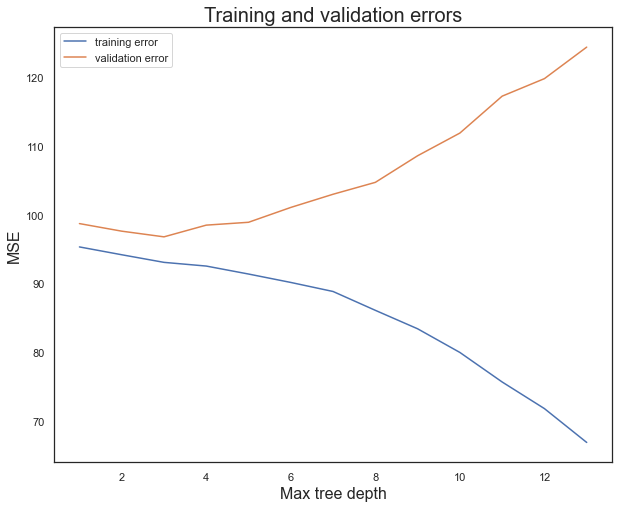

In [38]:
plt.figure(figsize=(10,8))
plt.plot(range(1,14,1),tr_errors, label="training error")
plt.plot(range(1,14,1),val_errors, label="validation error")
plt.legend(loc="best")    
plt.ylabel('MSE',fontsize=16)
plt.xlabel('Max tree depth',fontsize=16)
plt.title(f'Training and validation errors',fontsize=20)
plt.show()

### How did this method do compared to Wolt

In [39]:
tree_regr = DecisionTreeRegressor(max_depth=best_tree_model, criterion="absolute_error")
tree_regr.fit(X_train,y_train)
tree_ypred = tree_regr.predict(X_test)
tree_mse = mean_squared_error(y_test,tree_ypred)
model_selection['Decision tree'] = tree_mse

print(tree_mse)

98.1136849607983


In [40]:
diff = y_test-tree_ypred

my_on_time = sum(np.where(diff==0, 1, 0))
my_within_5_min = sum(np.where(abs(diff)<=5, 1, 0))
my_within_10_min = sum(np.where(abs(diff)<=10, 1, 0))

print(f"{my_on_time} out of {len(y_test)} test predictions were exactly on time. So {round(my_on_time/len(y_test)*100,1)} % of orders were on time.")
print(f"{my_within_5_min} out of {len(y_test)} test predictions were ordered within 5 minutes of the estimated time. So {round(my_within_5_min/len(y_test)*100,1)} % of orders were within 5 minutes of estimated delivery.")
print(f"{my_within_10_min} out of {len(y_test)} test predictions were ordered within 10 minutes of the estimated time. So {round(my_within_10_min/len(y_test)*100,1)} % of orders were within 10 minutes of estimated delivery.")

179 out of 5612 test predictions were exactly on time. So 3.2 % of orders were on time.
2195 out of 5612 test predictions were ordered within 5 minutes of the estimated time. So 39.1 % of orders were within 5 minutes of estimated delivery.
3850 out of 5612 test predictions were ordered within 10 minutes of the estimated time. So 68.6 % of orders were within 10 minutes of estimated delivery.


# 8. Model Selection

In [41]:
model_selection

{'Lasso': 95.82393865290001, 'Decision tree': 98.1136849607983}

In [42]:
min(model_selection, key=model_selection.get)

'Lasso'

In [43]:
wolt_MSE

82.07564417833851

Based on the performance of the two models on the test data, decision tree worked better than Lasso regression.

Both models seriously underperformed compared to Wolt's model.

# 9. Conclusion

In this notebook, I
- did exploratory data analysis,
- performed feature engineering and feature selection,
- trained two regression models, Lasso and decision tree, and
- compared the two models performance with each other and Wolt.

The other notebook includes map visualizations of the dataset.